# 04b: Face Pose with dlib

Use dlib's HoG/SVG detector to locate a face and then calculate pose.  

This is based on the post by Satya Mallick
https://www.learnopencv.com/head-pose-estimation-using-opencv-and-dlib/


In [1]:
import os
import os.path as osp
import cv2
import numpy as np
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import math
import dlib
%reload_ext autoreload
%autoreload 2
from utils import imx # Image function extensions
from config import config as cfg

In [2]:
def detect_faces_dlib(im,pyramids=0):
    rects = detector(im, pyramids)
    faces = [ (r.left(),r.top(),r.right(),r.bottom()) for r in rects] #x1,y1,x2,y2
    return faces

In [3]:
# init dlib
dlib_predictor_path = osp.join(cfg.MODELS_DIR,'dlib/shape_predictor_68_face_landmarks.dat')
predictor = dlib.shape_predictor(dlib_predictor_path)
detector = dlib.get_frontal_face_detector()

In [4]:
# Read an image and display it
fpath = osp.join(cfg.IMAGES_DIR,'test/biden.jpg')
im = cv2.imread(fpath)
src = cv2.imread(fpath)
im_gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

In [5]:
# Draw high-confidence faces
faces = detect_faces_dlib(im,pyramids=0)
print("Found {} face(s)".format(len(faces)))

Found 1 face(s)


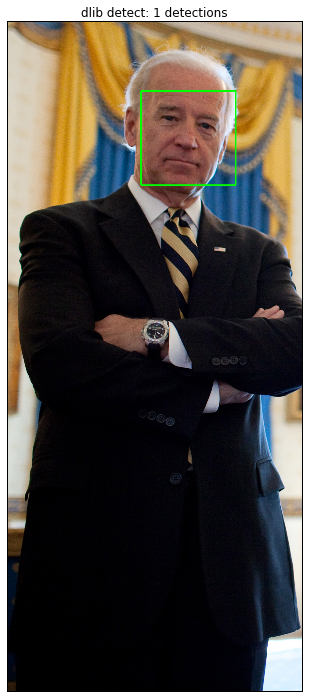

In [8]:
# Draw faces
dst = im.copy()
for face in faces:
    x1,y1,x2,y2 = face
    cv2.rectangle(dst,(x1,y1),(x2,y2),(0,255,0),3)

title='dlib detect: {} detections'.format(len(faces))
imx.pltimg(dst,mode='bgr',title=title)

In [10]:
# Copied from https://www.learnopencv.com/head-pose-estimation-using-opencv-and-dlib/
def get_pose(img, pose_points):
    size = img.shape
    # Camera internals
    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 1, 1]], dtype = "double"
    )

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rot_vec, tran_vec) = cv2.solvePnP(
    model_points, pose_points, 
    camera_matrix, dist_coeffs, 
    flags=cv2.SOLVEPNP_ITERATIVE)
    
    print "Rotation Vector:\n {0}".format(rot_vec)
    print "Translation Vector:\n {0}".format(tran_vec)

    # Project a 3D point (0, 0, 1000.0) onto the image plane.
    # We use this to draw a line sticking out of the nose
    return (success, rot_vec, tran_vec,camera_matrix)

In [23]:
regions = {
    "outside_mouth": {
        "points": list(range(49, 60+1)),
        "closed": True
        },
    "inside_mouth": {
        "points": list(range(61, 68)),
        "closed": True
        },
    "brow_left": {
        "points": list(range(18, 22+1)),
        "closed": False
        },
    "brow_right": {
        "points": list(range(23, 27+1)),
        "closed": False
        },
    "eye_right": {
        "points": list(range(37, 42+1)),
        "closed": True
        },
    "eye_left": {
        "points": list(range(43, 48+1)),
        "closed": True
        },
    "nose_bottom": {
        "points": list(range(31,36+1)),
        "closed": True
        },
    "nose_bridge": {
        "points": list(range(28,31+1)),
        "closed": False
        },
    "jaw": {
        "points": list(range(1, 17+1)),
        "closed": False
    }
}

In [11]:
det

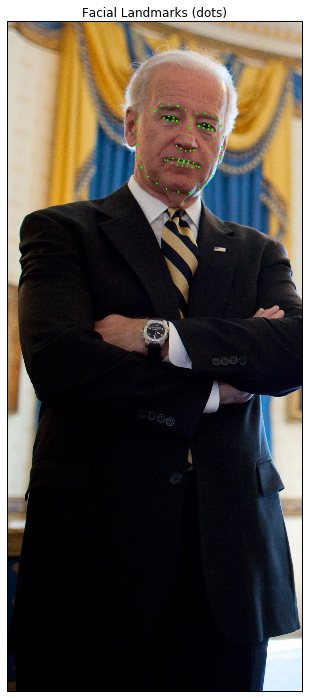

In [14]:
# Draw landmarks as dots
dst = im.copy()
for lm in landmarks:
    cv2.circle(dst,(lm[0],lm[1]), 3, (0,255,0), -1)

imx.pltimg(dst,mode='bgr',title='Facial Landmarks (dots)')

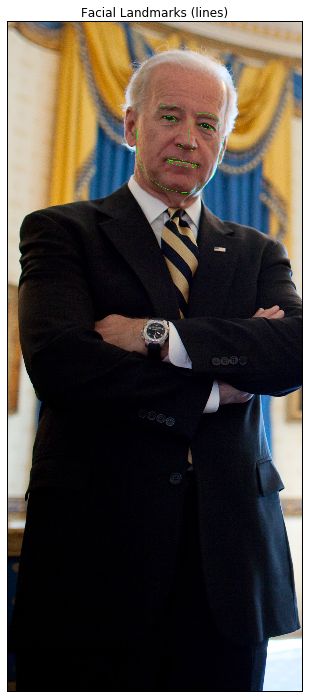

In [26]:
# Draw landmarks as lines in groups
dst = im.copy()

rclosed = False
for region in regions:
    x2 = None
    y2 = None
    rclosed = regions[region]['closed']
    for pt in regions[region]['points']:
        pos = landmarks[pt-1]
        x1,y1 = (landmarks[pt-1][0],landmarks[pt-1][1])
        if x2 is not None:
             cv2.line(dst,(x1,y1),(x2,y2),(0,255,0),1)
        x2,y2 = (x1,y1)
        
    if rclosed:
        pt = regions[region]['points'][0]
        x2,y2 = (landmarks[pt-1][0],landmarks[pt-1][1])
        cv2.line(dst,(x1,y1),(x2,y2),(0,255,0),1)
        
imx.pltimg(dst,mode='bgr',title='Facial Landmarks (lines)')

Rotation Vector:
 [[-2.68290225]
 [-0.16073118]
 [-0.25112493]]
Translation Vector:
 [[  280.77648944]
 [-1783.27987888]
 [ 2480.32220914]]
[[[ 774.06108935  445.51183766]]]


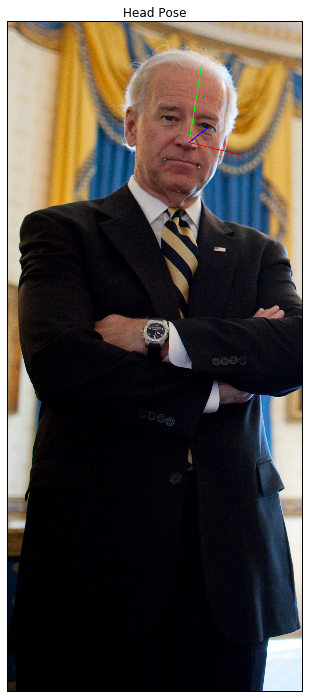

In [16]:
dst = im.copy()

pose_points_idx = (30,8,36,45,48,54)

# 3D model points.
model_points = np.array([
    (0.0, 0.0, 0.0),             # Nose tip
    (0.0, -330.0, -65.0),        # Chin
    (-225.0, 170.0, -135.0),     # Left eye left corner
    (225.0, 170.0, -135.0),      # Right eye right corne
    (-150.0, -150.0, -125.0),    # Left Mouth corner
    (150.0, -150.0, -125.0)      # Right mouth corner
])
dist_coeffs = np.zeros((4,1))
rot_vec = None
size = im_gray.shape

pose_points = []
for j,pidx in enumerate(pose_points_idx):
    landmarks = [[p.x, p.y] for p in predictor(im_gray, roi_dlib).parts()]
    ff = landmarks[pidx]
    pose_points.append((ff[0],ff[1]))

pose_points = np.array(pose_points, dtype='double')
(success, rot_vec, tran_vec, cam_mat) = get_pose(im_gray, pose_points)
if success:
    # X vector
    (nose_end_point2D_x, jacobian) = cv2.projectPoints(
        np.array([(500.0, 0.0, 0)]),
        rot_vec, 
        tran_vec, 
        cam_mat,
        dist_coeffs)
    # Y vector
    (nose_end_point2D_y, jacobian) = cv2.projectPoints(
        np.array([(0.0, 500.0, 0)]),
        rot_vec, 
        tran_vec, 
        cam_mat,
        dist_coeffs)
    # Z vector
    (nose_end_point2D_z, jacobian) = cv2.projectPoints(
        np.array([(0.0, 0.0, 500.0)]),
        rot_vec, 
        tran_vec, 
        cam_mat,
        dist_coeffs)
    
    
for x,y in pose_points:
    cv2.circle(dst,(int(x),int(y)),3,(255,255,0))

# X
print(nose_end_point2D_x)
p1 = ( int(pose_points[0][0]), int(pose_points[0][1]))
p2 = ( int(nose_end_point2D_x[0][0][0]), int(nose_end_point2D_x[0][0][1]))
cv2.line(dst,p1,p2,(0,0,255),2)

# Y
p1 = ( int(pose_points[0][0]), int(pose_points[0][1]))
p2 = ( int(nose_end_point2D_y[0][0][0]), int(nose_end_point2D_y[0][0][1]))
cv2.line(dst,p1,p2,(0,255,0),2)

# Z
p1 = ( int(pose_points[0][0]), int(pose_points[0][1]))
p2 = ( int(nose_end_point2D_z[0][0][0]), int(nose_end_point2D_z[0][0][1]))
cv2.line(dst,p1,p2,(255,0,0),2)

imx.pltimg(dst,mode='bgr',title='Head Pose')